# Validation from external data

### initialize definitions

In [1]:
suppressMessages(suppressWarnings(source(here::here("code/init.R"))))

### Get A/B meth data

In [2]:
m <- fread(here("output/ebd_day1_to_day4_cpg_meth_mat.tsv")) %>% as_tibble() %>% filter(!is.na(dAB))

In [3]:
m <- gextract.left_join("DNMT.ab_score_xgb_plus", intervals = m %>% select(chrom, start, end, dAB), iterator = m, colnames="score") %>% select(-(chrom1:end1)) %>% select(chrom, start, end, dAB, score) %>% as_tibble()

### Get Meissner data

In [4]:
md <- tribble(~track_name, ~sort, ~num,
    "Meissner_Nature_2017.Epi_Dnmt3a_1", "ko3a", 1,
    "Meissner_Nature_2017.Epi_Dnmt3a_2", "ko3a", 2,
    "Meissner_Nature_2017.Epi_Dnmt3a_4", "ko3a", 4,
    "Meissner_Nature_2017.Epi_Dnmt3a_5", "ko3a", 5,
    "Meissner_Nature_2017.Epi_Dnmt3a_6", "ko3a", 6,
    "Meissner_Nature_2017.Epi_Dnmt3b_1", "ko3b", 1,
    "Meissner_Nature_2017.Epi_Dnmt3b_2", "ko3b", 2,
    "Meissner_Nature_2017.Epi_Dnmt3b_3", "ko3b", 3,
    "Meissner_Nature_2017.Epi_Dnmt3b_4", "ko3b", 4,
    "Meissner_Nature_2017.Epi_Dnmt3b_5", "ko3b", 5,
    "Meissner_Nature_2017.Epi_Dnmt3b_6", "ko3b", 6,
    "Meissner_Nature_2017.Epi_WT_4", "wt", 4,
    "Meissner_Nature_2017.Epi_WT_5", "wt", 5,
    "Meissner_Nature_2017.Epi_WT_6", "wt", 6,
    "Meissner_Nature_2017.Epi_WT_7", "wt", 7) %>% 
        mutate(name = paste0(sort, "_", num))
        
m_all_epi6 <- gextract_meth(tracks = md$track_name, names=md$name, intervals=m %>% select(chrom, start, end), extract_meth_calls = TRUE, iterator = m %>% select(chrom, start, end)) %cache_df% here("output/meissner_epi_cpg_meth.tsv")  %>% as_tibble()    

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/Dnmt3ab_EB/methylation/output/meissner_epi_cpg_meth.tsv'



In [5]:
min_cov <- 10
m_epi6 <- m_all_epi6 %>% select(chrom, start, end)
for (g in unique(md$sort)){
        nms <- md %>% filter(sort == g) %>% pull(name)

        cov_col <- paste0(g, ".cov")
        meth_col <- paste0(g, ".meth")            

        m_epi6[[cov_col]] <- rowSums(m_all_epi6[, paste0(nms, ".cov")], na.rm=TRUE)
        m_epi6[[meth_col]] <- rowSums(m_all_epi6[, paste0(nms, ".meth")], na.rm=TRUE)
        
        m_epi6[[g]] <- ifelse(m_epi6[[cov_col]] >= min_cov, m_epi6[[meth_col]] / m_epi6[[cov_col]], NA)
    }
m_epi6 <- m_epi6 %>% select(-ends_with(".meth"), -ends_with(".cov"))  %cache_df% here("output/meissner_epi_cpg_meth_sum.tsv")

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/Dnmt3ab_EB/methylation/output/meissner_epi_cpg_meth_sum.tsv'



In [6]:
df <- m_epi6 %>% mutate(dAB_epi6 = ko3a - ko3b) %>% filter(!is.na(dAB_epi6)) %>% select(chrom, start, end, dAB_epi6) %>% inner_join(m) %>% filter(!is.na(dAB))
dim(df)

Joining, by = c("chrom", "start", "end")


[1] 13388     6

### Figure 4H

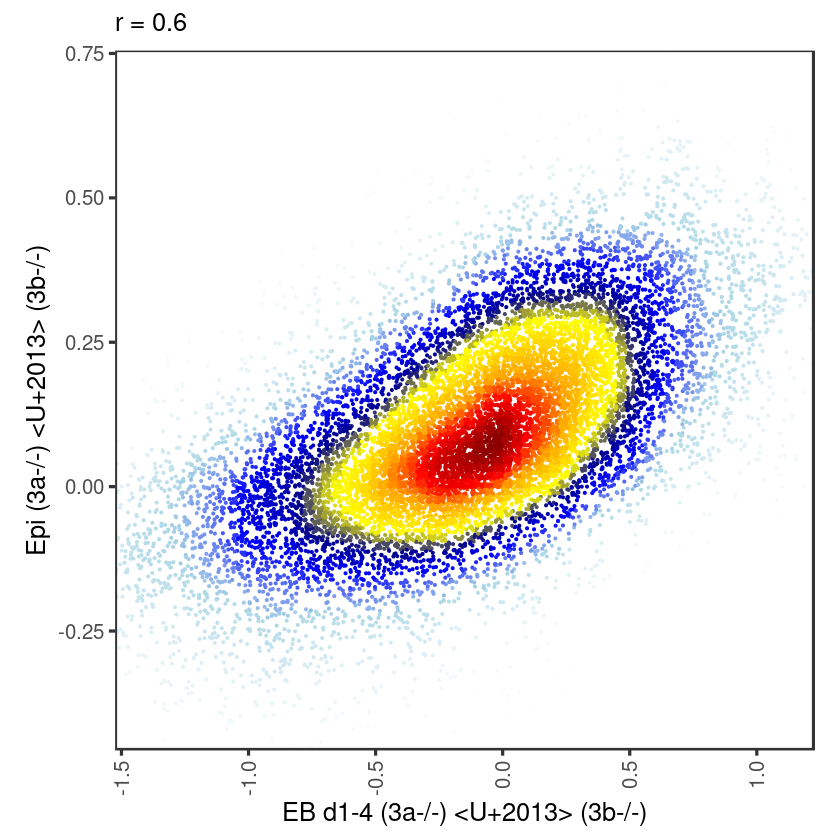

In [7]:
bandwidth <- 0.06
point_size = 0.1
p_epi6_meth <- df %>% 
    select(dAB, dAB_epi6) %>%
    mutate(col = densCols(., bandwidth=bandwidth,colramp=colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" )))) %>% 
    ggplot(aes(x=dAB, y=dAB_epi6, col=col)) + 
        geom_point(shape=19, size=point_size) + 
        scale_color_identity() + 
        coord_cartesian(xlim = c(-1.4, 1.1), ylim = c(-0.4, 0.7)) +         
        xlab("EB d1-4 (3a-/-) – (3b-/-)") + 
        ylab("Epi (3a-/-) – (3b-/-)") +         
        theme(aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + 
        labs(subtitle = glue("r = {cor}", cor = round(cor(df$dAB_epi6, df$dAB), digits=2)))
p_epi6_meth

[1] 0.63

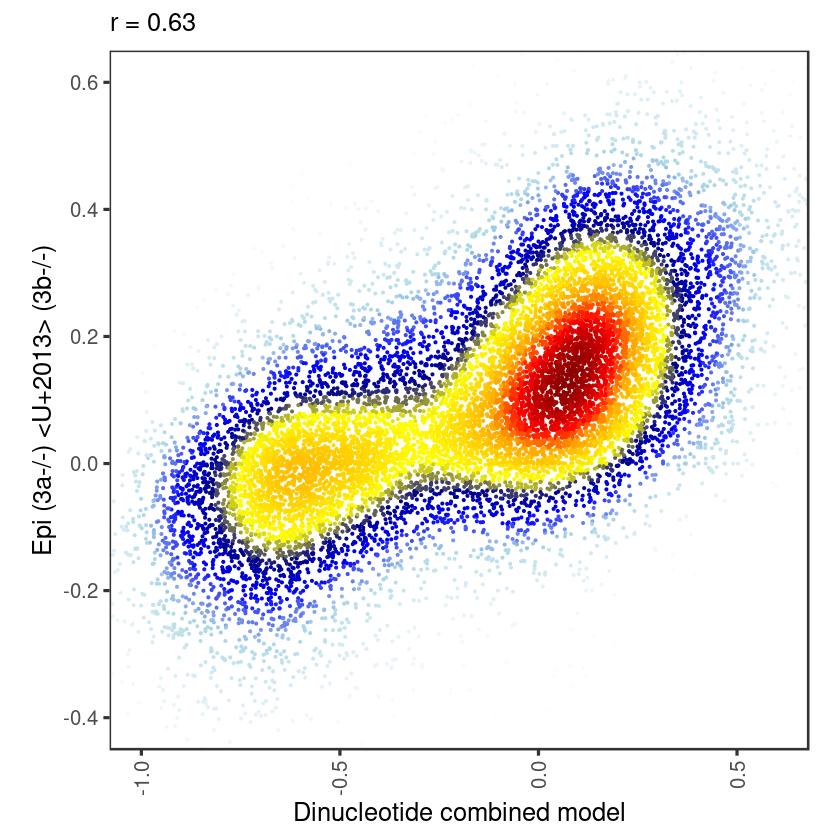

In [8]:
p_epi6_score <- df %>% 
    select(score, dAB_epi6) %>%
    mutate(col = densCols(., bandwidth=bandwidth,colramp=colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" )))) %>% 
    ggplot(aes(x=score, y=dAB_epi6, col=col)) + 
        geom_point(shape=19, size=point_size) + 
        scale_color_identity() + 
        coord_cartesian(xlim = c(-1, 0.6), ylim = c(-0.4, 0.6)) +         
        xlab("Dinucleotide combined model") + 
        ylab("Epi (3a-/-) – (3b-/-)") +         
        theme(aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + 
        labs(subtitle = glue("r = {cor}", cor = round(cor(df$dAB_epi6, df$score), digits=2)))
round(cor(df$dAB_epi6, df$score), digits=2)
p_epi6_score

In [9]:
weber_tracks <- gtrack.ls("Web.+8_5.+avg")
weber_nms <- gsub("Weber_Genome_Biol_2014.","", weber_tracks)
weber_capt <- gextract.left_join(weber_tracks, intervals=m, iterator=m, colnames=weber_nms) %>% as_tibble()

In [10]:
df_weber <- weber_capt %>% mutate(ko3a = pmean(E8_5_3AKO_Rep1.avg, E8_5_3AKO_Rep2.avg, na.rm=TRUE), ko3b = pmean(E8_5_3BKO_Rep1.avg, E8_5_3BKO_Rep2.avg, na.rm=TRUE)) %>% mutate(dAB_e8.5 = ko3a - ko3b) %>% filter(!is.na(dAB_e8.5), !is.na(dAB))  %>% select(chrom, start, end, dAB_e8.5, score, dAB)

### Figure 4I

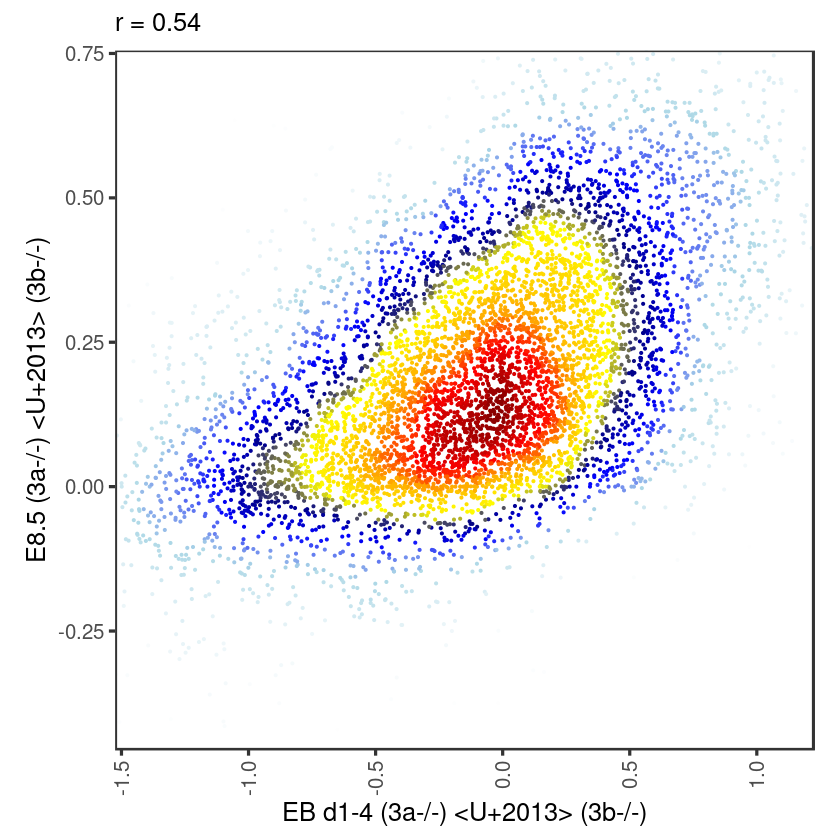

In [11]:
bandwidth <- 0.06
point_size = 0.1
p_e8.5_meth <- df_weber %>% 
    select(dAB, dAB_e8.5) %>%
    mutate(col = densCols(., bandwidth=bandwidth,colramp=colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" )))) %>% 
    ggplot(aes(x=dAB, y=dAB_e8.5, col=col)) + 
        geom_point(shape=19, size=point_size) + 
        scale_color_identity() + 
        coord_cartesian(xlim = c(-1.4, 1.1), ylim = c(-0.4, 0.7)) +         
        xlab("EB d1-4 (3a-/-) – (3b-/-)") + 
        ylab("E8.5 (3a-/-) – (3b-/-)") +         
        theme(aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + 
        labs(subtitle = glue("r = {cor}", cor = round(cor(df_weber$dAB_e8.5, df_weber$dAB), digits=2)))
p_e8.5_meth

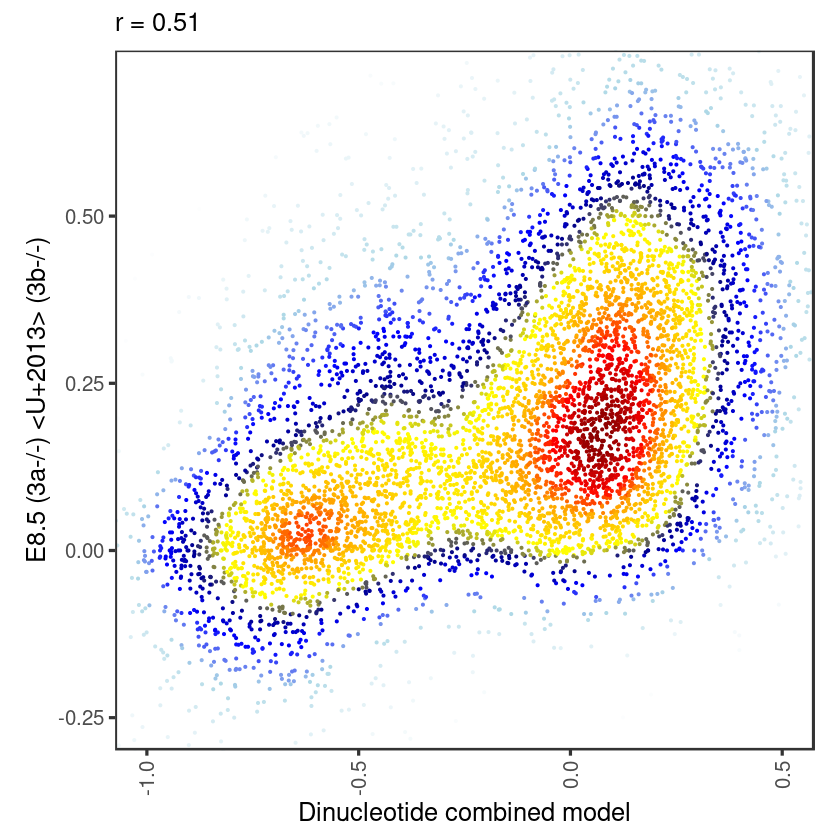

In [12]:
p_e8.5_score <- df_weber %>% 
    select(score, dAB_e8.5) %>%
    mutate(col = densCols(., bandwidth=bandwidth,colramp=colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" )))) %>% 
    ggplot(aes(x=score, y=dAB_e8.5, col=col)) + 
        geom_point(shape=19, size=point_size) + 
        scale_color_identity() + 
        coord_cartesian(xlim = c(-1, 0.5), ylim = c(-0.25, 0.7)) +         
        xlab("Dinucleotide combined model") + 
        ylab("E8.5 (3a-/-) – (3b-/-)") +         
        theme(aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + 
        labs(subtitle = glue("r = {cor}", cor = round(cor(df_weber$dAB_e8.5, df_weber$score), digits=2)))
p_e8.5_score